In [1]:
import sys,os,glob,copy
import numpy as np
import pyslha
import pandas as pd
import ROOT
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d,griddata,LinearNDInterpolator
from ATLAS_data.effFunctions import (getMuonRecoEff,getTriggerEff,getTrackEff,
                                     getSelectionEff,getTargetMass,getMassSelEff)

# os.environ['ROOT_INCLUDE_PATH'] = os.path.abspath('./MG5/Delphes/external')

ROOT.gSystem.Load(os.path.abspath("./MG5/Delphes/libDelphes.so"))


ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "figure.figsize" : (8,6),
    "lines.linewidth" : 3.0,
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.24/06


Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootTreeReader.h
   requested to autoload type ExRootTreeReader
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootTreeWriter.h
   requested to autoload type ExRootTreeWriter
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootTreeBranch.h
   requested to autoload type ExRootTreeBranch
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootResult.h
   requested to autoload type ExRootResult
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootClassifier.h
   requested to autoload type ExRootClassifier
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootFilter.h
   requested to autoload type ExRootFil

In [2]:
parameters = pyslha.readSLHAFile('./pp2C1N1/Cards/param_card.dat')
mLLP = parameters.blocks['MASS'][1000024]
mDM = parameters.blocks['MASS'][1000022]
width = parameters.decays[1000024].totalwidth
if width:
    tau_ns = (6.582e-25/width)*1e9
else:
    tau_ns = np.inf

In [3]:
inputFiles = {'stable' : './pp2C1N1/Events/run_04/tag_2_delphes_events.root'}
# xsecsPB = {'stable' : 7.133e-3, 'prompt' : 7.133e-3}

### Loop over events, apply basic selection criterium and compute masses

In [10]:
weightsDict = {}
massesDict = {}
gbetaDict = {}
metDict = {}
newMetDict = {}
metCaloDict = {}
genMetDict = {}

for label,inputFile in inputFiles.items():

    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    
    gbetaDict[label] = []
    metDict[label] = []
    newMetDict[label] = []
    metCaloDict[label] = []
    genMetDict[label] = []
    weightsDict[label] = []
    isolation = []
    rdecay = []
    totalWeight = 0.0
    totalWeight60 = 0.0
    srWeights = {}
    
    acceptanceWeight = 0.0
    eventLevelWeight = 0.0
    srLowWeight = 0.0
    srHighWeight = 0.0

    weights = []
    masses = []
    nevts = 5000
    print('Reading %i events' %nevts)
    for ievt in range(nevts):
        tree.GetEntry(ievt)
        weight = tree.Event.At(0).Weight
        totalWeight += weight
        met = tree.MissingET.At(0).MET
        metCalo = tree.MissingETCalo.At(0).MET
        genMet = tree.GenMissingET.At(0).MET
        metDict[label].append(met)
        metCaloDict[label].append(metCalo)
        genMetDict[label].append(genMet)
        
        
        
        hscpCandidates = []
        charginos = []
        neutralinos = []
        for iptc in range(tree.Particle.GetEntries()):
            particle = tree.Particle.At(iptc)
            if abs(particle.PID) == 1000024 and particle.Status ==1:
                charginos.append(particle)
            elif abs(particle.PID) == 1000022 and particle.Status ==1:
                neutralinos.append(particle)
            # Get HSCP
            if abs(particle.Charge) != 1: # Skip neutral particles
                continue
            if particle.Mass < 20.: # Skip light (SM) particles
                continue
            if particle.Status != 1: # If HSCP is unstable check if it is the last step
                d1 = particle.D1
                d2 = particle.D2
                daughters = [tree.Particle.At(d) for d in range(d1,d2+1)]
                if any(daughter.PID == particle.PID for daughter in daughters):
                    continue
                # Get the HSCP decay radius from the first daughter production vertex:
                r_decay = np.sqrt(daughters[0].X**2 +daughters[0].Y**2)      
                z_decay = daughters[0].Z
            else:
                r_decay = np.inf
                z_decay = np.inf
                
            # Add decay position
            particle.r_decay = r_decay
            rdecay.append(r_decay)
            particle.z_decay = z_decay
            # Add beta and gamma*beta
            p = np.sqrt(particle.Px**2 +particle.Py**2 + particle.Pz**2)
            particle.beta = p/particle.E
            particle.gbeta = p/particle.Mass
            hscpCandidates.append(particle)
        
#         if len(charginos) != len(hscpCandidates):
#             print('Found %i charginos and %i HSCP candidates' %(len(charginos),len(hscpCandidates)))
#             break
            
        # Get gaugino pair pT
        px = sum([hscp.Px for hscp in hscpCandidates])+sum([n1.Px for n1 in neutralinos])
        py = sum([hscp.Py for hscp in hscpCandidates])+sum([n1.Py for n1 in neutralinos])
        gauginoPT = np.sqrt(px**2 + py**2)
        if gauginoPT > 60.:
            totalWeight60 += weight
            
        # Apply selection to HSCP candidates (following ATLAS snippet)
        hscpCandidates = [hscp for hscp in hscpCandidates[:] 
                          if (hscp.PT > 120. and abs(hscp.Eta) < 1.8 
                              and hscp.r_decay > 500.0)]
        
            
        if hscpCandidates and gauginoPT > 60.0:
            acceptanceWeight += weight       
            
        # Apply isolation requirement for HSCP tracks
        tracks = tree.Track
        for hscp in hscpCandidates:
            sumPT = 0.0
            for itrk in range(tracks.GetEntries()):
                track = tracks.At(itrk)
                if abs(track.PID) > 10000:
                    print(track.PID)
                deltaR = np.sqrt((track.Phi-hscp.Phi)**2 +(track.Eta-hscp.Eta)**2)
                if deltaR > 0.3:
                    continue
                sumPT += track.PT
            hscp.iso = sumPT
            isolation.append(sumPT)
        # Remove non-isolated HSCPs
        hscpCandidates = [hscp for hscp in hscpCandidates[:] if hscp.iso < 5.0]
        
        if not hscpCandidates:
            continue
        
        hscps = hscpCandidates[:]
        muonsLLP = []
        # Get probability of tagging the HSCP as muon:
        for hscp in hscpCandidates:
            if hscp.r_decay < 3.9e3 and hscp.z_decay < 6e3: # Skip decays before MS
                continue
            beta = hscp.beta
            eta = abs(hscp.Eta)
            eff = getMuonRecoEff(beta,eta,hscp.PID)
            # Randomly reconstrunct the HSCP as a muon
            if np.random.uniform() < eff:
                muonsLLP.append(hscp)
        
        if muonsLLP:
            # Remove muonsLLp from MET:            
            pxTot = sum([m.Px for m in muonsLLP])
            pyTot = sum([m.Py for m in muonsLLP])
            metx = met*np.cos(tree.MissingET.At(0).Phi)
            mety = met*np.sin(tree.MissingET.At(0).Phi)
            newMet = np.sqrt((metx-pxTot)**2 + (mety-pyTot)**2)
            met = newMet
        newMetDict[label].append(met)
        
        if not hscps:
            continue         
#         if met < 170.0:
#             continue
            
        triggerEff = getTriggerEff(metCalo)
        eventEff = getSelectionEff(met)
        
        hscpEffs = {'SR-Inclusive_High' : [], 'SR-Inclusive_Low' : [], 'targetMass' : []}
        for hscp in hscps:
            gbeta = hscp.gbeta
            gbetaDict[label].append(gbeta)
            targetMass = getTargetMass(hscp.Mass)
            if targetMass is None:
                continue # Skip event if mass is outside all the mass windows
            trackEffHigh = getTrackEff(gbeta,sr='High',use='smear')
            trackEffLow = getTrackEff(gbeta,sr='Low',use='smear')
            wMassLow = getMassSelEff(targetMass,sr='Low')
            wMassHigh = getMassSelEff(targetMass,sr='High')
            hscpEffs['SR-Inclusive_High'].append(trackEffHigh*wMassHigh)
            hscpEffs['SR-Inclusive_Low'].append(trackEffLow*wMassLow)
            hscpEffs['targetMass'].append(targetMass)
                      
        if not hscpEffs['targetMass']:
            continue
        
        # If the HSCPs have distinct masses, use the highest one:
        targetMass = max(hscpEffs['targetMass'])
        # Total event weight
        hscpLow = np.array(hscpEffs['SR-Inclusive_Low'])
        eventWeightLow = weight*triggerEff*eventEff*(1-np.prod(1.0-hscpLow))

        hscpHigh = np.array(hscpEffs['SR-Inclusive_High'])
        eventWeightHigh = weight*triggerEff*eventEff*(1-np.prod(1.0-hscpHigh))

        # Collect intermediate efficiencies for validation
        if gauginoPT > 60.0:
            eventLevelWeight += weight*triggerEff*eventEff
            srLowWeight += weight*triggerEff*eventEff*(1-np.prod(1.0-hscpLow/wMassLow))
            srHighWeight += weight*triggerEff*eventEff*(1-np.prod(1.0-hscpHigh/wMassHigh))
        
        
        if not targetMass in srWeights:
            srWeights[targetMass] = {'Low' : 0.0, 'High' : 0.0}
        srWeights[targetMass]['Low'] += eventWeightLow
        srWeights[targetMass]['High'] += eventWeightHigh

    # weights = np.array(weights)
    # masses = np.array(masses)
    # weightsDict[label] = weights
    # massesDict[label] = masses
print('Total cross-section = ',totalWeight/nevts)
print('SR=',srWeights)

Reading 5000 events
Total cross-section =  0.022875523194670677
SR= {700.0: {'Low': 0.07211065734040714, 'High': 0.06398307861277355}}


In [11]:
# Debug info:
# ATLAS values for stable charginos with mass = 600 GeV
# (S95_Low = 15, S95_High = 4.2, totalXsec = 2.85e-2 pb, xsecUL = 1.52e-3 pb, lumi = 139/fb)
print('Mass = %1.1f GeV, lifetime = %1.2f ns:' %(mLLP,tau_ns)) 
print('\t acceptance = %1.3f' %(acceptanceWeight/totalWeight60)) # 0.737
print('\t event-level efficiency = %1.3f' %(eventLevelWeight/acceptanceWeight)) # 0.156
print('\t efficiency for SR-Inclusive_High = %1.3f' %(srHighWeight/acceptanceWeight)) # 0.033
print('\t efficiency for SR-Inclusive_Low = %1.3f' %(srLowWeight/acceptanceWeight)) # 0.021

Mass = 599.9 GeV, lifetime = 1.00 ns:
	 acceptance = 0.099
	 event-level efficiency = 0.134
	 efficiency for SR-Inclusive_High = 0.009
	 efficiency for SR-Inclusive_Low = 0.012


### Check ATLAS official values

In [12]:
mLLP = 599.0
tau_ns = np.inf
charginoData = pd.read_pickle('./ATLAS_data/charginoData.pcl')
vals = charginoData[(charginoData['mass (GeV)'] == round(mLLP,-2)) 
                    & (charginoData['lifetime (ns)'] == round(tau_ns,0))]
vals

,mass (GeV),lifetime (ns),width (GeV),acceptance,event eff,SR-Inclusive_Low eff,SR-Inclusive_High eff,Expected Limit (pb),Observed Limit (pb),Signal Cross-Section (pb)
97,600.0,inf,0.0,0.737,0.156,0.021,0.033,0.00161,0.00152,0.0285


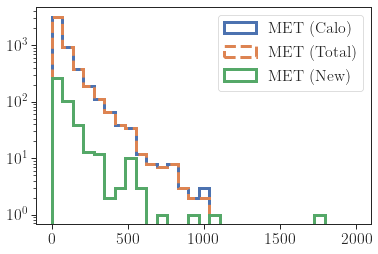

In [6]:
bins = np.linspace(0.,2000.,30)
plt.hist(metCaloDict['stable'],bins=bins,label='MET (Calo)',histtype='step',linewidth=3)
plt.hist(metDict['stable'],bins=bins,label='MET (Total)',histtype='step',linewidth=3,linestyle='--')
plt.hist(newMetDict['stable'],bins=bins,label='MET (New)',histtype='step',linewidth=3)
plt.yscale('log')
plt.legend()
plt.show()

In [7]:
print(np.array(metCaloDict['stable']).mean(),np.array(metCaloDict['stable']).std())

84.2139040784061 113.66430493551118


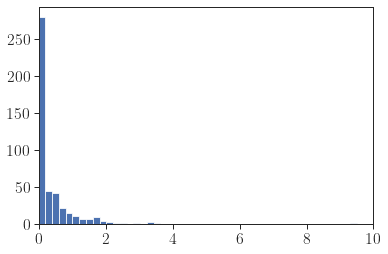

In [8]:
plt.hist(isolation,bins=np.linspace(0.,20.,100))
plt.xlim(0,10)
plt.show()

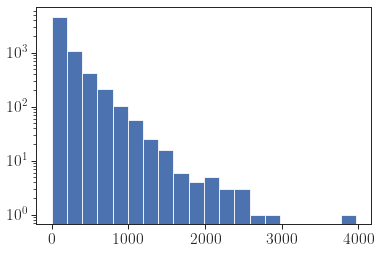

In [9]:
plt.hist(rdecay,bins=20)
plt.yscale('log')
plt.show()